# Objective

The primary goal of this project is to develop a recommendation system that utilizes a user-friendly Flask application to suggest recipes based on a given list of ingredients. By employing the TF-IDF (Term Frequency-Inverse Document Frequency) technique, the system will analyze ingredient input from users and generate relevant recipe recommendations along with their corresponding URLs. This will enable users to efficiently discover recipes that align with the ingredients they have on hand, thereby enhancing their cooking experience and minimizing food waste. The project aims to combine data processing, machine learning, and web development to create an intuitive platform that connects users with culinary resources tailored to their preferences.


In [1]:
import pandas as pd
import ast
from gensim.models import Word2Vec
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import joblib

# Load the dataset

In [2]:
df = pd.read_csv('JamieOliver_full.csv')

In [3]:
df.head()

,recipe_urls,recipe_name,serves,cooking_time,difficulty,ingredients
0,https://www.jamieoliver.com/recipes/duck-recip...,Roast duck with Marsala gravy,6 ...,2 hours 20 minutes ...,Not too tricky ...,"['1 x 1.6kg whole duck', '2 heaped teaspoons C..."
1,https://www.jamieoliver.com/recipes/vegetable-...,Best-ever Brussels sprouts,6 as a side ...,30 minutes ...,Not too tricky ...,"['800 g Brussels sprouts', '2 higher-welfare C..."
2,https://www.jamieoliver.com/recipes/pasta-reci...,Beautiful courgette carbonara,6 ...,20 minutes ...,Not too tricky ...,"['6 medium green and yellow courgettes', '500 ..."
3,https://www.jamieoliver.com/recipes/vegetable-...,Roasted black bean burgers,4 ...,40 minutes ...,Not too tricky ...,"['1½ red onions', '200 g mixed mushrooms', '10..."
4,https://www.jamieoliver.com/recipes/chicken-re...,Chicken & tofu noodle soup,2 ...,1 hour 15 minutes plus chilling overnight ...,Not too tricky ...,"['2 shallots', '2 cloves of garlic', '2 cm pie..."


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 857 entries, 0 to 856
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   recipe_urls   857 non-null    object
 1   recipe_name   857 non-null    object
 2   serves        853 non-null    object
 3   cooking_time  847 non-null    object
 4   difficulty    856 non-null    object
 5   ingredients   857 non-null    object
dtypes: object(6)
memory usage: 40.3+ KB


# Data Cleaning - Feature Selection

In [5]:
# Specify columns to keep
columns_to_keep = ['recipe_urls', 'recipe_name', 'ingredients']

# Keeping only the specified columns
filtered_data = df[columns_to_keep]

# Display the filtered DataFrame
print("\nFiltered DataFrame:")
filtered_data



Filtered DataFrame:


,recipe_urls,recipe_name,ingredients
0,https://www.jamieoliver.com/recipes/duck-recip...,Roast duck with Marsala gravy,"['1 x 1.6kg whole duck', '2 heaped teaspoons C..."
1,https://www.jamieoliver.com/recipes/vegetable-...,Best-ever Brussels sprouts,"['800 g Brussels sprouts', '2 higher-welfare C..."
2,https://www.jamieoliver.com/recipes/pasta-reci...,Beautiful courgette carbonara,"['6 medium green and yellow courgettes', '500 ..."
3,https://www.jamieoliver.com/recipes/vegetable-...,Roasted black bean burgers,"['1½ red onions', '200 g mixed mushrooms', '10..."
4,https://www.jamieoliver.com/recipes/chicken-re...,Chicken & tofu noodle soup,"['2 shallots', '2 cloves of garlic', '2 cm pie..."
...,...,...,...
852,https://www.jamieoliver.com/recipes/vegetables...,Delicious squash daal,"['8 cloves of garlic', '2 fresh red chillies',..."
853,https://www.jamieoliver.com/recipes/chicken-re...,Chicken & squash cacciatore,"['1 onion', '1 leek', '4 cloves of garlic', '2..."
854,https://www.jamieoliver.com/recipes/vegetables...,Apple & Lancashire cheese pie,"['500 g all butter puff pastry', '1 vegetable ..."
855,https://www.jamieoliver.com/recipes/chicken-re...,All-in-one rice & chicken,"['olive oil', '2 free-range chicken legs', '2 ..."


In [6]:

# Display filtered DataFrame info
print("\nFiltered DataFrame Info:")
print(filtered_data.info())


Filtered DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 857 entries, 0 to 856
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   recipe_urls  857 non-null    object
 1   recipe_name  857 non-null    object
 2   ingredients  857 non-null    object
dtypes: object(3)
memory usage: 20.2+ KB
None


# Data Wrangling

# Step 1: Clean and Prepare the Ingredients

In [8]:
import pandas as pd
import nltk
import string
import ast
import re
import unidecode
from nltk.stem import WordNetLemmatizer

# Make sure to download required NLTK data files
# nltk.download('wordnet')

def ingredient_parser(ingreds):
    '''
    This function takes in a list (as a string from pandas dataframe) of 
    ingredients and performs some preprocessing.
    '''
    # Define measures and common words to remove
    measures = [
        'teaspoon', 'tablespoon', 'fluid ounce', 'cup', 'pint', 'quart', 'gallon',
        'ml', 'liter', 'gram', 'kilogram', 'oz', 'mg', 'l', 'ml', 'inch', 'pound'
        # Add any additional measures if needed
    ]
    words_to_remove = [
        'fresh', 'oil', 'a', 'red', 'bunch', 'and', 'clove', 'leaf', 'large',
        'ground', 'small', 'sliced', 'green', 'the', 'to', 'organic', 'optional',
        'salt', 'pepper', 'with', 'for', 'can', 'more', 'half', 'whole', 'cubed',
        # Add any additional words to remove
    ]

    # Convert the string of ingredients back into a list
    if isinstance(ingreds, list):
        ingredients = ingreds
    else:
        ingredients = ast.literal_eval(ingreds)

    # Initialize the lemmatizer
    lemmatizer = WordNetLemmatizer()
    cleaned_ingredients = []

    for ingredient in ingredients:
        # Remove punctuation
        ingredient = ingredient.translate(str.maketrans('', '', string.punctuation))
        
        # Split ingredients into words
        items = re.split(r'\s+|-', ingredient)
        
        # Clean up the words
        items = [unidecode.unidecode(word).lower() for word in items if word.isalpha()]
        items = [lemmatizer.lemmatize(word) for word in items]

        # Filter out measures and common words
        items = [word for word in items if word not in measures and word not in words_to_remove]

        # Join cleaned items back into a string if not empty
        if items:
            cleaned_ingredients.append(' '.join(items))

    return cleaned_ingredients

if __name__ == "__main__":
    
    # Apply the ingredient parser to the ingredients column
    filtered_data['ingredients_parsed'] = filtered_data['ingredients'].apply(ingredient_parser)
    
    # Drop any rows with NaN values
    df = filtered_data.dropna(subset=['ingredients_parsed'])
    
    # Clean up recipe names if needed
    m = df.recipe_name.str.endswith('Recipe - Allrecipes.com')
    df.loc[m, 'recipe_name'] = df.loc[m, 'recipe_name'].str[:-23]

 

    # Optional: Check the output
    print(df[['recipe_name', 'ingredients_parsed']].head())


                     recipe_name  \
0  Roast duck with Marsala gravy   
1     Best-ever Brussels sprouts   
2  Beautiful courgette carbonara   
3     Roasted black bean burgers   
4     Chicken & tofu noodle soup   

                                  ingredients_parsed  
0  [x duck, heaped chinese fivespice powder, clem...  
1  [g brussels sprout, higherwelfare cumberland s...  
2  [medium yellow courgette, g penne, freerange e...  
3  [onion, g mixed mushroom, g rye bread, coriand...  
4  [shallot, of garlic, cm piece of ginger, freer...  


/var/folders/l6/74m9w2hs6dg1jnknmb5cj5940000gn/T/ipykernel_4757/4232906245.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['ingredients_parsed'] = filtered_data['ingredients'].apply(ingredient_parser)


In [9]:
def flatten_ingredients(ingredients_list):
    """Flattens a list of lists into a single list."""
    return [ingredient for sublist in ingredients_list for ingredient in sublist]


In [10]:
from collections import Counter

# Flatten the lists of parsed ingredients
all_parsed_ingredients = flatten_ingredients(df['ingredients_parsed'])

# Count the frequency of each ingredient
ingredient_counts = Counter(all_parsed_ingredients)


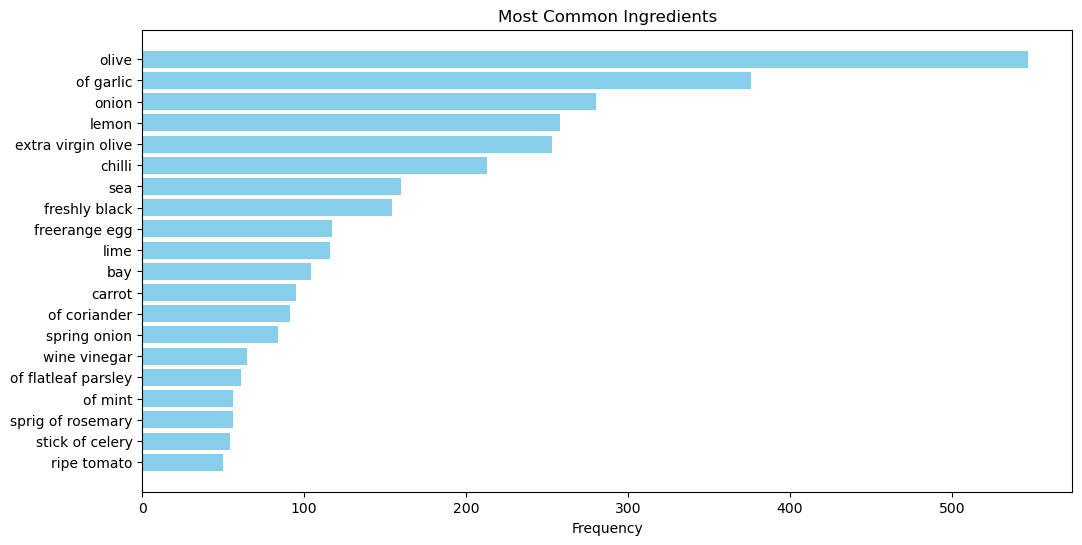

In [11]:
import matplotlib.pyplot as plt

# Get the most common ingredients
common_ingredients = ingredient_counts.most_common(20)
ingredients, counts = zip(*common_ingredients)

# Plot the frequency of the most common ingredients
plt.figure(figsize=(12, 6))
plt.barh(ingredients, counts, color='skyblue')
plt.xlabel('Frequency')
plt.title('Most Common Ingredients')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest on top
plt.show()


# Feature Extraction

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer


df['ingredients_aggregated'] = df['ingredients_parsed'].apply(lambda x: ' '.join(x))

# Initialize the TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer()

# Fit and transform the ingredients
tfidf_matrix = tfidf_vectorizer.fit_transform(df['ingredients_aggregated'])

# Print the shape of the TF-IDF matrix
print(tfidf_matrix.shape)  # (number_of_recipes, number_of_unique_ingredients)
# Save the TF-IDF model and vectorizer
joblib.dump(tfidf_vectorizer, 'tfidf_vectorizer.pkl')
joblib.dump(tfidf_matrix, 'tfidf_matrix.pkl')  
joblib.dump(df, 'recipe_data.pkl')


(857, 1553)


['recipe_data.pkl']

# Recommendation Logic

In [37]:

# Function to recommend recipes based on given ingredients
def recommend_recipes(input_ingredients, num_recommendations=5):
    # Aggregate the input ingredients into a single string
    input_ingredients_str = ' '.join(input_ingredients)

    # Transform the input ingredients using the same TF-IDF Vectorizer
    input_tfidf = tfidf_vectorizer.transform([input_ingredients_str])

    # Calculate cosine similarity between the input and the recipe TF-IDF matrix
    cosine_similarities = cosine_similarity(input_tfidf, tfidf_matrix)

    # Get the similarity scores and sort them
    similarity_scores = list(enumerate(cosine_similarities[0]))
    similarity_scores = sorted(similarity_scores, key=lambda x: x[1], reverse=True)

    # Get the indices of the top N recommendations
    recommended_indices = [i[0] for i in similarity_scores[1:num_recommendations + 1]]

    return df.iloc[recommended_indices]

In [40]:
# Example usage
input_ingredients = ['chicken', 'curry', 'onion']  # Example input ingredients
recommended_recipes = recommend_recipes(input_ingredients, num_recommendations=5)
print(recommended_recipes[['recipe_name', 'ingredients_aggregated']])

                                 recipe_name  \
856                           Aubergine daal   
59                      Spicy sticky chicken   
184  Summery pea soup with turmeric scallops   
495                       Pukka yellow curry   
5                        Chicken katsu curry   

                                ingredients_aggregated  
856  aubergine onion of garlic cm piece of ginger r...  
59   chilli onion of garlic plum tomato of coriande...  
184  of spring onion of garlic piece of ginger chil...  
495  onion of garlic cm piece of ginger yellow chic...  
5    x freerange skinless boneless chicken breast b...  


In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 857 entries, 0 to 856
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   recipe_urls             857 non-null    object
 1   recipe_name             857 non-null    object
 2   ingredients             857 non-null    object
 3   cleaned_ingredients     857 non-null    object
 4   ingredients_parsed      857 non-null    object
 5   ingredients_aggregated  857 non-null    object
dtypes: object(6)
memory usage: 40.3+ KB


In [42]:
df.head()

,recipe_urls,recipe_name,ingredients,cleaned_ingredients,ingredients_parsed,ingredients_aggregated
0,https://www.jamieoliver.com/recipes/duck-recip...,Roast duck with Marsala gravy,"['1 x 1.6kg whole duck', '2 heaped teaspoons C...","[., -spice_powder, , , gravy, , , , , , , ]","[x duck, heaped chinese fivespice powder, clem...",x duck heaped chinese fivespice powder clement...
1,https://www.jamieoliver.com/recipes/vegetable-...,Best-ever Brussels sprouts,"['800 g Brussels sprouts', '2 higher-welfare C...","[, -welfare_cumberland_sausages, ½_a_bunch_of_...","[g brussels sprout, higherwelfare cumberland s...",g brussels sprout higherwelfare cumberland sau...
2,https://www.jamieoliver.com/recipes/pasta-reci...,Beautiful courgette carbonara,"['6 medium green and yellow courgettes', '500 ...","[, , -range_eggs, , , olive_oil, -welfare_back...","[medium yellow courgette, g penne, freerange e...",medium yellow courgette g penne freerange egg ...
3,https://www.jamieoliver.com/recipes/vegetable-...,Roasted black bean burgers,"['1½ red onions', '200 g mixed mushrooms', '10...","[, , , ground_coriander, , olive_oil, , , , , ...","[onion, g mixed mushroom, g rye bread, coriand...",onion g mixed mushroom g rye bread coriander x...
4,https://www.jamieoliver.com/recipes/chicken-re...,Chicken & tofu noodle soup,"['2 shallots', '2 cloves of garlic', '2 cm pie...","[, , , -range_chicken_thighs_,_skin_off,_bone_...","[shallot, of garlic, cm piece of ginger, freer...",shallot of garlic cm piece of ginger freerange...


In [48]:
def recommend_recipes(input_ingredients, num_recommendations=5):
    # Load the TF-IDF vectorizer and recipe data
    tfidf_vectorizer = joblib.load('tfidf_vectorizer.pkl')
    df = joblib.load('recipe_data.pkl')

    # Aggregate the input ingredients into a single string
    input_ingredients_str = ' '.join(input_ingredients)

    # Transform the input ingredients using the same TF-IDF Vectorizer
    input_tfidf = tfidf_vectorizer.transform([input_ingredients_str])

    # Calculate cosine similarity between the input and the recipe TF-IDF matrix
    cosine_similarities = cosine_similarity(input_tfidf, tfidf_matrix)

    # Get the similarity scores and sort them
    similarity_scores = list(enumerate(cosine_similarities[0]))
    similarity_scores = sorted(similarity_scores, key=lambda x: x[1], reverse=True)

    # Get the indices of the top N recommendations
    recommended_indices = [i[0] for i in similarity_scores[1:num_recommendations + 1]]

    # Return recommended recipes and their URLs
    return df.iloc[recommended_indices][['recipe_name', 'recipe_urls']]

# Example usage
input_ingredients = ['chicken', 'curry', 'onion']  # Example input ingredients
recommended_recipes = recommend_recipes(input_ingredients, num_recommendations=5)
print(input_ingredients)
print(recommended_recipes)


['chicken', 'curry', 'onion']
                                 recipe_name  \
856                           Aubergine daal   
59                      Spicy sticky chicken   
184  Summery pea soup with turmeric scallops   
495                       Pukka yellow curry   
5                        Chicken katsu curry   

                                           recipe_urls  
856  https://www.jamieoliver.com/recipes/vegetables...  
59   https://www.jamieoliver.com/recipes/chicken-re...  
184  https://www.jamieoliver.com/recipes/seafood-re...  
495  https://www.jamieoliver.com/recipes/chicken-re...  
5    https://www.jamieoliver.com/recipes/chicken-re...  
